In [1]:
#import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import ndimage as ndi
from skimage import feature

## Prepare Event File For Edge Detection 
-  Open event file in ds9, make an annulus region around any bright sources and make new event file with bright source removed in xselect 
- If doing background subtraction later, this would be the time to make a background region file too

In [167]:
#navigate to event file location
%cd Desktop/SL_Analysis/60061213002/event_cl/

/Users/ellenthompson/Desktop/SL_Analysis/60061213002/event_cl


In [168]:
#plug in name of event file
name_of_event_file = "extracted_point_source.evt"

#define energy cut variables
energy_cut_channel_min = 36
energy_cut_channel_max = 1935

#region file parameters (style options set to DS9 default, in image coords)
parameters_string = "#Region file format: DS9 version 4.1\nglobal color=green dashlist=8 3 width=1 font= 'helvetica 10 normal roman' select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\nimage\npolygon"

#region file title, output location is same as input
region_file_title = "60061213002A01_polygon_reg"

In [169]:
#open data
hdul = fits.open(name_of_event_file)

#move into 2nd hdu
data = hdul[1].data

#define variables for det1x, det1y, and PI
DET1X = data["DET1X"]
DET1Y = data["DET1Y"]
PI = data["PI"]

## Energy Cut (might remove this option entirely)
- User defined low and high channels 
    - could rewrite to take in ev values instead
- Need to determine best bounds for SL? Variation differs between event files

In [161]:
#energy cut using PI column (background varies more across high than low energies)
del_PI_indices = [i for i, x in enumerate(PI) if x<=energy_cut_channel_min or x>=energy_cut_channel_max]
cut_DET1X = np.delete(DET1X, del_PI_indices)
cut_DET1Y = np.delete(DET1Y, del_PI_indices)

## Canny Edge Detection
- Note: plots generated here are oriented differently than when event file is loaded into ds9 but no translations necessary for region file to be correct
- Currently need to adjust sigma case-by-case such that plot shows no non-SL region edges identified as edges
- Currently finds edges for full region, have written some code that divides by detector 

In [162]:
#generate region file image WITH energy cut
cut_counts_arrays = np.histogram2d(cut_DET1X, cut_DET1Y, [360,360], range=[[0,360],[0,360]])
cut_counts = np.hstack(cut_counts_arrays[0])
cut_counts_binned = np.split(cut_counts,360)
im = np.column_stack(cut_counts_binned)

In [201]:
#generate region file WITHOUT energy cut
counts_arrays = np.histogram2d(DET1X,DET1Y, [360,360], range=[[0,360],[0,360]])
counts = np.hstack(counts_arrays[0])
counts_binned = np.split(counts,360)
im = np.column_stack(counts_binned)

In [180]:
#calculate standard deviation - this rule doesn't always work, often need to adjust sigma case-by-case
#returns same value for cut and uncut data
sigma = 10*np.std(cut_counts)

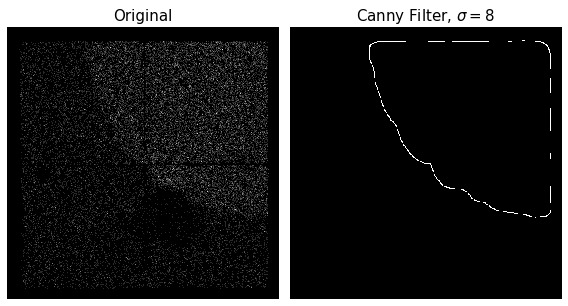

In [202]:
#compute the Canny filter, adjust sigma as necessary 
edges = feature.canny(im, sigma=8)
#display results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5), sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('Original', fontsize=15)

ax2.imshow(edges, cmap=plt.cm.gray)
ax2.axis('off')
#ax2.set_title(r'Canny Filter, $\sigma='+str(sigma)+'$', fontsize=15)
ax2.set_title(r'Canny Filter, $\sigma=8$', fontsize=15)

fig.tight_layout()

plt.show()

## Get Region File Coordinates
- Have only tried running for majority Detector 3 SL, may need to tweak for different orientations

In [196]:
#get detected edge coordinates 
indices = np.where(edges != [0])
x_coords = list(indices[1])
y_coords = list(indices[0])

#identify region polygon corners, start with deleting duplicate x coords
region_cols = list(set(x_coords)) 

#find SL curve perimeter coords
curve_perimeter_coords = []
for i in region_cols:
    if i in curve_perimeter_coords:
            pass
    else:
        curve_perimeter_coords.append(i)
        y_coord_indices =[j for j, x in enumerate(x_coords) if x == i]
        y_coords_for_i = []
        for i in y_coord_indices:
            y_coords_for_i.append(y_coords[i])
        curve_perimeter_coords.append(max(y_coords_for_i))

#start listing polygon corners with curve perimeter 
corners = []
for i in curve_perimeter_coords:
    corners.append(i)

#identify and add edge corners
upper_right_x = max(x_coords)
upper_right_y = curve_perimeter_coords[-1]
lower_right_x = max(x_coords)
lower_right_y = min(y_coords)
lower_left_x = min(x_coords)
lower_left_y = min(y_coords)

edge_corners = (upper_right_x,upper_right_y,lower_right_x,lower_right_y,lower_left_x,lower_left_y)

for i in edge_corners:
    corners.append(i)

In [197]:
#write region file
det2_region_file_title = region_file_title + ".reg"
det2_region_file = open(det2_region_file_title, "w")
det2_region_file.write(parameters_string + str(tuple(corners)))
det2_region_file.close()